<center><img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Cassava%20Leaf%20Disease%20Classification/banner.png" width="1000"></center>
<br>
<center><h1>Cassava Leaf - Supervised Contrastive Learning</h1></center>
<br>


- Dataset source `center cropped` [512x512](https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-50-tfrecords-center-512x512) - `divided by classes` [512x512](https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-50-tfrecords-classes-512x512)
- Dataset source `external data` `center cropped` [512x512](https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-50-tfrecords-external-512x512) - `divided by classes` [512x512](https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-ext-50-tfrec-classes-512x512)
- Dataset source [discussion thread](https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/198744)
- Dataset [creation source](https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-stratified-tfrecords-256x256)

## Supervised Contrastive Learning

### How it works?

> Clusters of points belonging to the same class
are pulled together in embedding space, while simultaneously pushing apart clusters of samples from different classes.


### Self Supervised Contrastive Learning vs Supervised Contrastive Learning

<center><img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Cassava%20Leaf%20Disease%20Classification/sscl_vs_scl.png" width="1000"></center>

<br>

> Supervised vs. self-supervised contrastive losses: The self-supervised contrastive loss (left)
contrasts a single positive for each anchor (i.e., an augmented version of the same image) against a set of
negatives consisting of the entire remainder of the batch. The supervised contrastive loss (right) considered
in this paper, however, contrasts the set of all samples from the same class as positives against the
negatives from the remainder of the batch. As demonstrated by the photo of the black and white puppy, taking
class label information into account results in an embedding space where elements of the same class are more
closely aligned than in the self-supervised case.

<br>

<center><img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Cassava%20Leaf%20Disease%20Classification/scl_training_setup.png" width="1000"></center>

<br>

> Cross entropy, self-supervised contrastive loss and supervised contrastive loss: The cross entropy
loss (left) uses labels and a softmax loss to train a classifier; the self-supervised contrastive loss (middle) uses
a contrastive loss and data augmentations to learn representations. The supervised contrastive loss (right) also
learns representations using a contrastive loss, but uses label information to sample positives in addition to
augmentations of the same image. Both contrastive methods can have an optional second stage which trains a
model on top of the learned representations.

References:
- [Supervised Contrastive Learning (Paper)](https://arxiv.org/pdf/2004.11362.pdf)
- [Supervised Contrastive Learning (Keras tutorial)](https://keras.io/examples/vision/supervised-contrastive-learning/)
- [Great videos reviewing the paper by Yannic Kilcher](https://www.youtube.com/watch?v=MpdbFLXOOIw)

### Supervised contrastive learning experiments summary

- What improved performance
 - Larger `batch size`
 - Average `encoder size`
 - `Data augmentation`
 - Lager `image resolution`
 - Using `pre-trained` weights, I tried training from scratch but the results were very poor.
 - `Oversampling` the minority classes from the dataset, gave a little help, but I expected more.
- What made no difference
 - `Temperature` parameter, according to the paper, lower `temperature` can benefit from longer training, since the data here is limited, tweaking this parameter maybe not worth it.
 - Different `projection heads`, I experimented a little with the number of neurons but got no relevant improvements.
 - Different `classifier heads`, I experimented a little with the number of neurons but got no relevant improvements.
- Next steps
 - Different `pooling` heads (AVG+MAX, Multi-sample, etc).
 - Different `optimizers`.
 - More elaborated `data augmentation` schedules (MixUp, CutMix, etc).
 - Use external data.
 - It may be interesting to try doing `2nd stage` training but fine-tuning the complete network.

## Dependencies

In [1]:
!pip install --quiet efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import math, os, re, warnings, random, time
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, losses, metrics, Model
import efficientnet.tfkeras as efn
import tensorflow_addons as tfa
from sklearn.manifold import TSNE


def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')

### Hardware configuration

In [3]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')


# Mixed precision
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_bfloat16')
mixed_precision.set_policy(policy)

# XLA
tf.config.optimizer.set_jit(True)

Running on TPU grpc://10.0.0.2:8470
REPLICAS: 8


# Model parameters

In [4]:
BATCH_SIZE = 64 * REPLICAS
LEARNING_RATE = 3e-5 * REPLICAS
EPOCHS_SCL = 15
EPOCHS = 10
HEIGHT = 512
WIDTH = 512
HEIGHT_RS = 512
WIDTH_RS = 512
CHANNELS = 3
N_CLASSES = 5
N_FOLDS = 5
FOLDS_USED = 1

# Load data

In [5]:
def count_data_items(filenames):
    n = [int(re.compile(r'-([0-9]*)\.').search(filename).group(1)) for filename in filenames]
    return np.sum(n)


database_base_path = '/kaggle/input/cassava-leaf-disease-classification/'
train = pd.read_csv(f'{database_base_path}train.csv')
print(f'Train samples: {len(train)}')

# Dataset paths
GCS_PATH = KaggleDatasets().get_gcs_path(f'cassava-leaf-disease-tfrecords-center-{HEIGHT}x{WIDTH}') # Center croped and resized (15 TFRecord)
GCS_PATH_EXT = KaggleDatasets().get_gcs_path(f'cassava-leaf-disease-tfrecords-external-{HEIGHT}x{WIDTH}') # Center croped and resized (15 TFRecord) (External)
GCS_PATH_CLASSES = KaggleDatasets().get_gcs_path(f'cassava-leaf-disease-tfrecords-classes-{HEIGHT}x{WIDTH}') # Center croped and resized (15 TFRecord) by classes
GCS_PATH_EXT_CLASSES = KaggleDatasets().get_gcs_path(f'cassava-leaf-disease-tfrecords-classes-ext-{HEIGHT}x{WIDTH}') # Center croped and resized (15 TFRecord) (External) by classes

# Dataset TFRecords
FILENAMES_COMP = tf.io.gfile.glob(GCS_PATH + '/*.tfrec')
FILENAMES_2019 = tf.io.gfile.glob(GCS_PATH_EXT + '/*.tfrec')

FILENAMES_COMP_CBB = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CBB*.tfrec')
FILENAMES_COMP_CBSD = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CBSD*.tfrec')
FILENAMES_COMP_CGM = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CGM*.tfrec')
FILENAMES_COMP_CMD = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CMD*.tfrec')
FILENAMES_COMP_Healthy = tf.io.gfile.glob(GCS_PATH_CLASSES + '/Healthy*.tfrec')

FILENAMES_2019_CBB = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CBB*.tfrec')
FILENAMES_2019_CBSD = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CBSD*.tfrec')
FILENAMES_2019_CGM = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CGM*.tfrec')
FILENAMES_2019_CMD = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CMD*.tfrec')
FILENAMES_2019_Healthy = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/Healthy*.tfrec')

TRAINING_FILENAMES = (FILENAMES_COMP + 
                      (10 * FILENAMES_COMP_CBB) + 
                      (5 * FILENAMES_COMP_CBSD) + 
                      (4 * FILENAMES_COMP_CGM) + 
                      (4 * FILENAMES_COMP_Healthy))
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)

print(f'GCS: train images: {NUM_TRAINING_IMAGES}')
display(train.head())

CLASSES = ['Cassava Bacterial Blight', 
           'Cassava Brown Streak Disease', 
           'Cassava Green Mottle', 
           'Cassava Mosaic Disease', 
           'Healthy']

Train samples: 21397
GCS: train images: 63048


image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

# Augmentation

In [6]:
def data_augment(image, label):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Shear
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, HEIGHT, shear=20.)
        else:
            image = transform_shear(image, HEIGHT, shear=-20.)
            
    # Rotation
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, HEIGHT, rotation=45.)
        else:
            image = transform_rotation(image, HEIGHT, rotation=-45.)
            
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
    # Crops
    if p_crop > .6:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.5)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .7:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    elif p_crop > .3:
        crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])

    if p_cutout > .5:
        image = data_augment_cutout(image)
        
    return image, label

## Auxiliary functions

In [7]:
# data augmentation @cdeotte kernel: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.uniform([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.uniform([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

# CutOut
def data_augment_cutout(image, min_mask_size=(int(HEIGHT * .1), int(HEIGHT * .1)), 
                        max_mask_size=(int(HEIGHT * .125), int(HEIGHT * .125))):
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_cutout > .85: # 10~15 cut outs
        n_cutout = tf.random.uniform([], 10, 15, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .6: # 5~10 cut outs
        n_cutout = tf.random.uniform([], 5, 10, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .25: # 2~5 cut outs
        n_cutout = tf.random.uniform([], 2, 5, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    else: # 1 cut out
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

def random_cutout(image, height, width, channels=3, min_mask_size=(10, 10), max_mask_size=(80, 80), k=1):
    assert height > min_mask_size[0]
    assert width > min_mask_size[1]
    assert height > max_mask_size[0]
    assert width > max_mask_size[1]

    for i in range(k):
      mask_height = tf.random.uniform(shape=[], minval=min_mask_size[0], maxval=max_mask_size[0], dtype=tf.int32)
      mask_width = tf.random.uniform(shape=[], minval=min_mask_size[1], maxval=max_mask_size[1], dtype=tf.int32)

      pad_h = height - mask_height
      pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
      pad_bottom = pad_h - pad_top

      pad_w = width - mask_width
      pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
      pad_right = pad_w - pad_left

      cutout_area = tf.zeros(shape=[mask_height, mask_width, channels], dtype=tf.uint8)

      cutout_mask = tf.pad([cutout_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
      cutout_mask = tf.squeeze(cutout_mask, axis=0)
      image = tf.multiply(tf.cast(image, tf.float32), tf.cast(cutout_mask, tf.float32))

    return image

In [8]:
# Datasets utility functions
def decode_image(image_data):
    """
        Decode a JPEG-encoded image to a uint8 tensor.
    """
    image = tf.image.decode_jpeg(image_data, channels=3)
    return image

def scale_image(image, label):
    """
        Cast tensor to float and normalizes (range between 0 and 1).
    """
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label

def prepare_image(image, label):
    """
        Resize and reshape images to the expected size.
    """
    image = tf.image.resize(image, [HEIGHT_RS, WIDTH_RS])
    image = tf.reshape(image, [HEIGHT_RS, WIDTH_RS, 3])
    return image, label

def read_tfrecord(example, labeled=True):
    """
        1. Parse data based on the 'TFREC_FORMAT' map.
        2. Decode image.
        3. If 'labeled' returns (image, label) if not (image, name).
    """
    if labeled:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'target': tf.io.FixedLenFeature([], tf.int64), 
        }
    else:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'image_name': tf.io.FixedLenFeature([], tf.string), 
        }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    if labeled:
        label_or_name = tf.cast(example['target'], tf.int32)
        # One-Hot Encoding needed to use "categorical_crossentropy" loss
#         label_or_name = tf.one_hot(tf.cast(label_or_name, tf.int32), N_CLASSES)
    else:
        label_or_name = example['image_name']
    return image, label_or_name

def get_dataset(FILENAMES, labeled=True, ordered=False, repeated=False, 
                cached=False, augment=False):
    """
        Return a Tensorflow dataset ready for training or inference.
    """
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
        dataset = tf.data.Dataset.list_files(FILENAMES)
        dataset = dataset.interleave(tf.data.TFRecordDataset, num_parallel_calls=AUTO)
    else:
        dataset = tf.data.TFRecordDataset(FILENAMES, num_parallel_reads=AUTO)
        
    dataset = dataset.with_options(ignore_order)
    
    dataset = dataset.map(lambda x: read_tfrecord(x, labeled=labeled), num_parallel_calls=AUTO)
    
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
        
    dataset = dataset.map(scale_image, num_parallel_calls=AUTO)
    dataset = dataset.map(prepare_image, num_parallel_calls=AUTO)
    
    if not ordered:
        dataset = dataset.shuffle(2048)
    if repeated:
        dataset = dataset.repeat()
        
    dataset = dataset.batch(BATCH_SIZE)
    
    if cached:
        dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

In [9]:
# Visualization utility functions
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', 
                  fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
    
# Visualize model predictions
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis=-1)
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(label, str(correct), ', shoud be ' if not correct else '',
                                correct_label if not correct else ''), correct

def display_one_flower_eval(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=14, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
    subplot=331
    plt.figure(figsize=(13,13))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_flower_eval(image, title, subplot, not correct)
        if i >= 8:
            break;
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


# Model evaluation
def plot_metrics(history):
    fig, axes = plt.subplots(2, 1, sharex='col', figsize=(20, 8))
    axes = axes.flatten()
    
    axes[0].plot(history['loss'], label='Train loss')
    axes[0].plot(history['val_loss'], label='Validation loss')
    axes[0].legend(loc='best', fontsize=16)
    axes[0].set_title('Loss')
    axes[0].axvline(np.argmin(history['loss']), linestyle='dashed')
    axes[0].axvline(np.argmin(history['val_loss']), linestyle='dashed', color='orange')
    
    axes[1].plot(history['sparse_categorical_accuracy'], label='Train accuracy')
    axes[1].plot(history['val_sparse_categorical_accuracy'], label='Validation accuracy')
    axes[1].legend(loc='best', fontsize=16)
    axes[1].set_title('Accuracy')
    axes[1].axvline(np.argmax(history['sparse_categorical_accuracy']), linestyle='dashed')
    axes[1].axvline(np.argmax(history['val_sparse_categorical_accuracy']), linestyle='dashed', color='orange')

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()
    
    
def visualize_embeddings(embeddings, labels, figsize=(16, 16)):
    # Extract TSNE values from embeddings
    embed2D = TSNE(n_components=2, n_jobs=-1, random_state=seed).fit_transform(embeddings)
    embed2D_x = embed2D[:,0]
    embed2D_y = embed2D[:,1]

    # Create dataframe with labels and TSNE values
    df_embed = pd.DataFrame({'labels': labels})
    df_embed = df_embed.assign(x=embed2D_x, y=embed2D_y)

    # Create classes dataframes
    df_embed_cbb = df_embed[df_embed['labels'] == 0]
    df_embed_cbsd = df_embed[df_embed['labels'] == 1]
    df_embed_cgm = df_embed[df_embed['labels'] == 2]
    df_embed_cmd = df_embed[df_embed['labels'] == 3]
    df_embed_healthy = df_embed[df_embed['labels'] == 4]
    
    # Plot embeddings
    plt.figure(figsize=figsize)
    plt.scatter(df_embed_cbb['x'], df_embed_cbb['y'],color='yellow',s=10,label='CBB')
    plt.scatter(df_embed_cbsd['x'], df_embed_cbsd['y'],color='blue',s=10,label='CBSD')
    plt.scatter(df_embed_cgm['x'], df_embed_cgm['y'],color='red',s=10,label='CGM')
    plt.scatter(df_embed_cmd['x'], df_embed_cmd['y'],color='orange',s=10,label='CMD')
    plt.scatter(df_embed_healthy['x'], df_embed_healthy['y'],color='green',s=10,label='Healthy')

    plt.legend()
    plt.show()

# Training data samples (with augmentation)

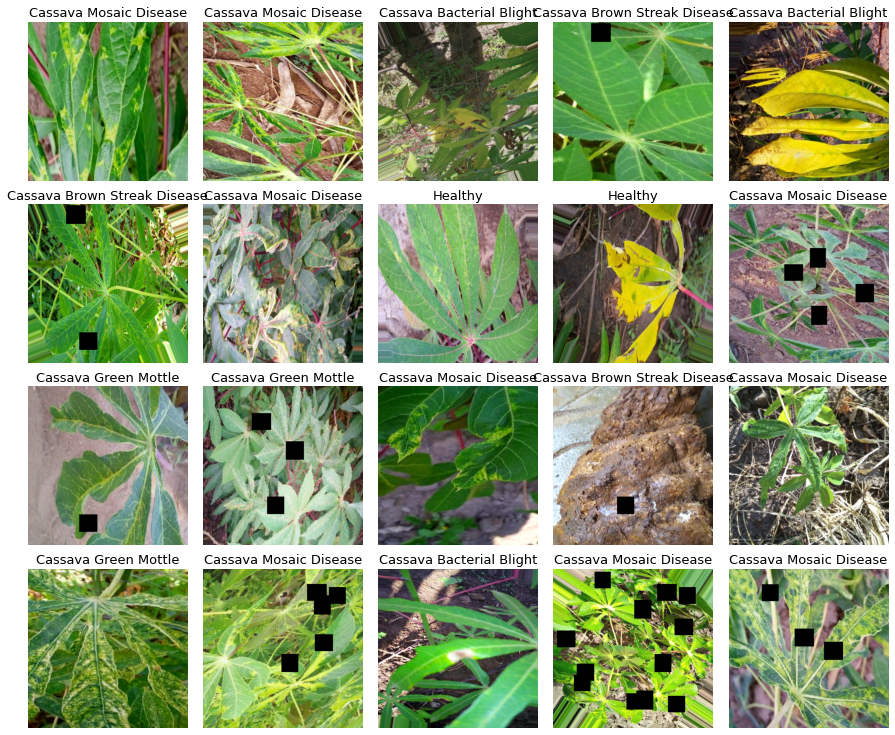

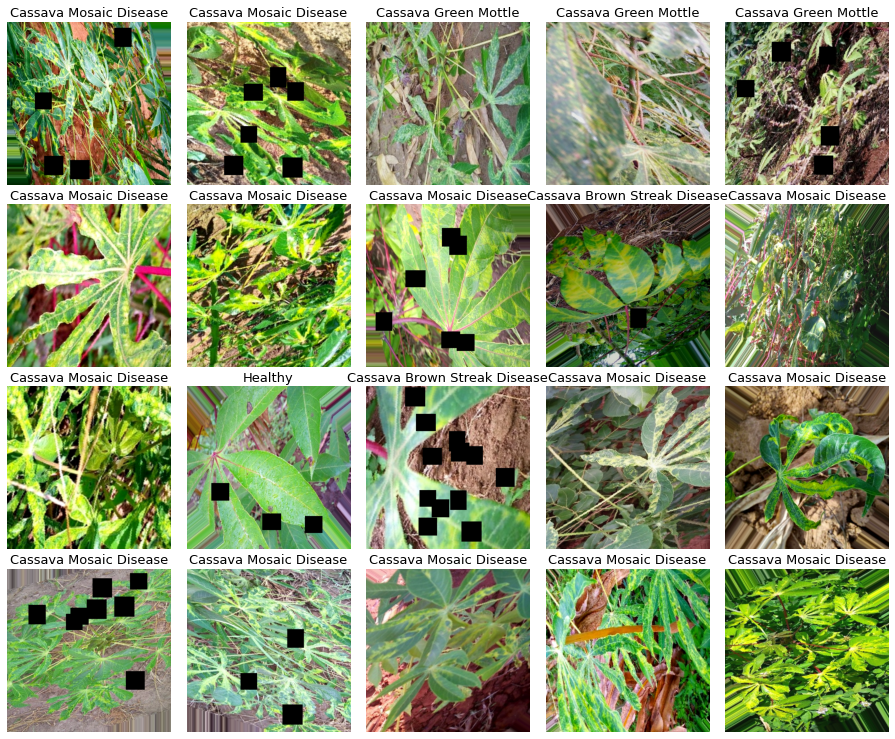

In [10]:
train_dataset = get_dataset(FILENAMES_COMP, ordered=True, augment=True)
train_iter = iter(train_dataset.unbatch().batch(20))

display_batch_of_images(next(train_iter))
display_batch_of_images(next(train_iter))

# Dataset distribution (oversampled)

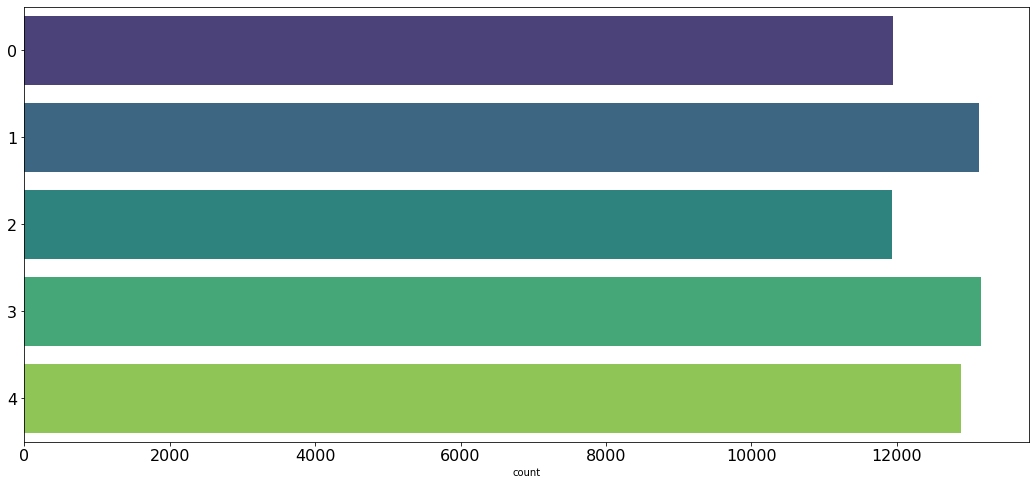

In [11]:
ds_dist = get_dataset(TRAINING_FILENAMES)
labels_comp = [target.numpy() for img, target in iter(ds_dist.unbatch())]

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax = sns.countplot(y=labels_comp, palette='viridis')
ax.tick_params(labelsize=16)

plt.show()

### Learning rate schedule

We are going to use a `cosine learning rate schedule with a warm-up phase`, this may be a good idea since we are using a pre-trained model, the warm-up phase will be useful to avoid the pre-trained weights degradation resulting in catastrophic forgetting, during the schedule the learning rate will slowly decrease to very low values, this helps the model to land on more stable weights.

1230 total steps and 123 steps per epoch
Learning rate schedule: 1e-08 to 0.00024 to 1e-08


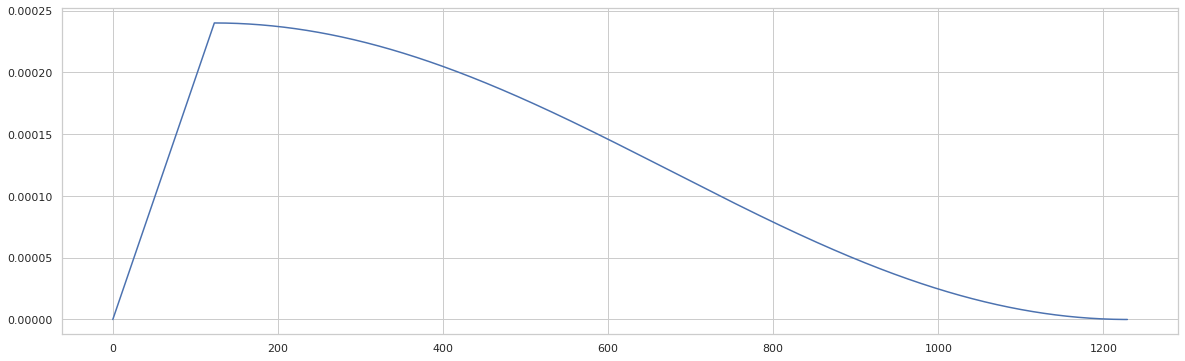

In [12]:
lr_start = 1e-8
lr_min = 1e-8
lr_max = LEARNING_RATE
num_cycles = 1.
warmup_epochs = 1
hold_max_epochs = 0
total_epochs = EPOCHS
warmup_steps = warmup_epochs * (NUM_TRAINING_IMAGES//BATCH_SIZE)
hold_max_steps = hold_max_epochs * (NUM_TRAINING_IMAGES//BATCH_SIZE)
total_steps = total_epochs * (NUM_TRAINING_IMAGES//BATCH_SIZE)

@tf.function
def cosine_schedule_with_warmup(step, total_steps, warmup_steps=0, hold_max_steps=0, 
                                lr_start=1e-4, lr_max=1e-3, lr_min=None, num_cycles=0.5):
    if step < warmup_steps:
        lr = (lr_max - lr_start) / warmup_steps * step + lr_start
    else:
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        lr = lr_max * (0.5 * (1.0 + tf.math.cos(np.pi * ((num_cycles * progress) % 1.0))))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, float(lr))

    return lr


rng = [i for i in range(total_steps)]
y = [cosine_schedule_with_warmup(tf.cast(x, tf.float32), total_steps, warmup_steps, hold_max_steps, 
                                 lr_start, lr_max, lr_min, num_cycles) for x in rng]

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

print(f'{total_steps} total steps and {NUM_TRAINING_IMAGES//BATCH_SIZE} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

# Model

In [13]:
def encoder_fn(input_shape):
    inputs = L.Input(shape=input_shape, name='inputs')
    base_model = efn.EfficientNetB3(input_tensor=inputs, 
                                    include_top=False, 
                                    weights='noisy-student', 
                                    pooling='avg')
    
    model = Model(inputs=inputs, outputs=base_model.outputs)

    return model


def classifier_fn(input_shape, N_CLASSES, encoder, trainable=True):
    for layer in encoder.layers:
        layer.trainable = trainable
        
    inputs = L.Input(shape=input_shape, name='inputs')
    
    features = encoder(inputs)
    features = L.Dropout(.5)(features)
    features = L.Dense(1000, activation='relu')(features)
    features = L.Dropout(.5)(features)
    outputs = L.Dense(N_CLASSES, activation='softmax', name='outputs', dtype='float32')(features)

    model = Model(inputs=inputs, outputs=outputs)

    return model

### Supervised Contrastive learning parameters

In [14]:
temperature = 0.1

class SupervisedContrastiveLoss(losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(input_shape, encoder):
    inputs = L.Input(shape=input_shape, name='inputs')
    features = encoder(inputs)
    outputs = L.Dense(128, activation='relu', name='projection_head', dtype='float32')(features)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Training (regular training)

In [15]:
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
oof_reg_pred = []; oof_reg_labels = []; oof_reg_embed = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    if fold >= FOLDS_USED:
        break
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')

    # Create train and validation sets
    FILENAMES_COMP = tf.io.gfile.glob([GCS_PATH + '/Id_train%.2i*.tfrec' % x for x in idxT])
#     FILENAMES_2019 = tf.io.gfile.glob([GCS_PATH_EXT + '/Id_train%.2i*.tfrec' % x for x in idxT])

    FILENAMES_COMP_CBB = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CBB%.2i*.tfrec' % x for x in idxT])
    FILENAMES_COMP_CBSD = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CBSD%.2i*.tfrec' % x for x in idxT])
    FILENAMES_COMP_CGM = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CGM%.2i*.tfrec' % x for x in idxT])
    FILENAMES_COMP_Healthy = tf.io.gfile.glob([GCS_PATH_CLASSES + '/Healthy%.2i*.tfrec' % x for x in idxT])
    
#     FILENAMES_2019_CBB = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/CBB%.2i*.tfrec' % x for x in idxT])
#     FILENAMES_2019_CBSD = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/CBSD%.2i*.tfrec' % x for x in idxT])
#     FILENAMES_2019_CGM = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/CGM%.2i*.tfrec' % x for x in idxT])
#     FILENAMES_2019_Healthy = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/Healthy%.2i*.tfrec' % x for x in idxT])

    TRAIN_FILENAMES = (FILENAMES_COMP + 
#                        FILENAMES_2019 + 
                       (10 * FILENAMES_COMP_CBB) + 
#                        (2 * FILENAMES_2019_CBB) + 
                       (5 * FILENAMES_COMP_CBSD) + 
#                        (2 * FILENAMES_2019_CBSD) + 
                       (4 * FILENAMES_COMP_CGM) + 
#                        (2 * FILENAMES_2019_CGM) + 
                       (4 * FILENAMES_COMP_Healthy) 
#                        (2 * FILENAMES_2019_Healthy)
                      )
    VALID_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/Id_train%.2i*.tfrec' % x for x in idxV])
    np.random.shuffle(TRAIN_FILENAMES)
    ct_train = count_data_items(TRAIN_FILENAMES)
    step_size = (ct_train // BATCH_SIZE)
    total_steps = EPOCHS * step_size
    
    # Model
    with strategy.scope():
        encoder_reg = encoder_fn((None, None, CHANNELS))
        model_reg = classifier_fn((None, None, CHANNELS), N_CLASSES, encoder_reg)
        model_reg.summary()

        lr = lambda: cosine_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                 total_steps, warmup_steps, hold_max_steps, 
                                                 lr_start, lr_max, lr_min, num_cycles)
        optimizer = optimizers.Adam(learning_rate=lr)
        model_reg.compile(optimizer=optimizer, 
                          loss=losses.SparseCategoricalCrossentropy(), 
                          metrics=[metrics.SparseCategoricalAccuracy()])
            
    ## TRAIN
    history_reg = model_reg.fit(x=get_dataset(TRAIN_FILENAMES, repeated=True, augment=True), 
                                validation_data=get_dataset(VALID_FILENAMES, ordered=True, cached=True), 
                                steps_per_epoch=step_size, 
                                epochs=EPOCHS,  
                                verbose=1).history
    model_path = f'model_reg_{fold}.h5'
    model_reg.save_weights(model_path)
    
    ### RESULTS
    print(f"#### FOLD {fold+1} OOF Accuracy = {np.max(history_reg['val_sparse_categorical_accuracy']):.3f}")

    # OOF predictions
    ds_valid = get_dataset(VALID_FILENAMES, ordered=True)
    oof_reg_labels.append([target.numpy() for img, target in iter(ds_valid.unbatch())])
    x_oof = ds_valid.map(lambda image, target: image)
    oof_reg_pred.append(np.argmax(model_reg.predict(x_oof), axis=-1))
    oof_reg_embed.append(encoder_reg.predict(x_oof)) # OOF embeddings


FOLD: 1
TRAIN: [ 0  2  3  4  5  7  9 10 11 12 13 14] VALID: [1 6 8]
43933696/43933088 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, None, None, 3)]   0         
_________________________________________________________________
model (Model)                (None, 1536)              10783528  
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1000)              1537000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
outputs (Dense)              (None, 5)                 50

# Training (supervised contrastive learning)

In [16]:
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
oof_pred = []; oof_labels = []; oof_embed = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    if fold >= FOLDS_USED:
        break
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    K.clear_session()
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')

    # Create train and validation sets
    FILENAMES_COMP = tf.io.gfile.glob([GCS_PATH + '/Id_train%.2i*.tfrec' % x for x in idxT])
#     FILENAMES_2019 = tf.io.gfile.glob([GCS_PATH_EXT + '/Id_train%.2i*.tfrec' % x for x in idxT])

    FILENAMES_COMP_CBB = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CBB%.2i*.tfrec' % x for x in idxT])
    FILENAMES_COMP_CBSD = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CBSD%.2i*.tfrec' % x for x in idxT])
    FILENAMES_COMP_CGM = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CGM%.2i*.tfrec' % x for x in idxT])
    FILENAMES_COMP_Healthy = tf.io.gfile.glob([GCS_PATH_CLASSES + '/Healthy%.2i*.tfrec' % x for x in idxT])
    
#     FILENAMES_2019_CBB = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/CBB%.2i*.tfrec' % x for x in idxT])
#     FILENAMES_2019_CBSD = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/CBSD%.2i*.tfrec' % x for x in idxT])
#     FILENAMES_2019_CGM = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/CGM%.2i*.tfrec' % x for x in idxT])
#     FILENAMES_2019_Healthy = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/Healthy%.2i*.tfrec' % x for x in idxT])

    TRAIN_FILENAMES = (FILENAMES_COMP + 
#                        FILENAMES_2019 + 
                       (10 * FILENAMES_COMP_CBB) + 
#                        (2 * FILENAMES_2019_CBB) + 
                       (5 * FILENAMES_COMP_CBSD) + 
#                        (2 * FILENAMES_2019_CBSD) + 
                       (4 * FILENAMES_COMP_CGM) + 
#                        (2 * FILENAMES_2019_CGM) + 
                       (4 * FILENAMES_COMP_Healthy) 
#                        (2 * FILENAMES_2019_Healthy)
                      )    
    VALID_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/Id_train%.2i*.tfrec' % x for x in idxV])
    np.random.shuffle(TRAIN_FILENAMES)
       
    ct_train = count_data_items(TRAIN_FILENAMES)
    step_size = (ct_train // BATCH_SIZE)
    warmup_steps = warmup_epochs * step_size
    total_steps = EPOCHS_SCL * step_size

    ### Pre-train the encoder
    print('Pre-training the encoder using "Supervised Contrastive" Loss')
    with strategy.scope():
        encoder = encoder_fn((None, None, CHANNELS))
        encoder_proj = add_projection_head((None, None, CHANNELS), encoder)
        encoder_proj.summary()

        lr = lambda: cosine_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                 total_steps, warmup_steps, hold_max_steps, 
                                                 lr_start, lr_max, lr_min, num_cycles)
        optimizer = optimizers.Adam(learning_rate=lr)
        encoder_proj.compile(optimizer=optimizer, 
                             loss=SupervisedContrastiveLoss(temperature))
        
    history_enc = encoder_proj.fit(x=get_dataset(TRAIN_FILENAMES, repeated=True, augment=True), 
                                   validation_data=get_dataset(VALID_FILENAMES, ordered=True, cached=True), 
                                   steps_per_epoch=step_size, 
                                   batch_size=BATCH_SIZE, 
                                   epochs=EPOCHS_SCL,
                                   verbose=2).history

    
    ### Train the classifier with the frozen encoder
    print('Training the classifier with the frozen encoder')
    warmup_steps = 1
    total_steps = EPOCHS * step_size
    
    with strategy.scope():
        model = classifier_fn((None, None, CHANNELS), N_CLASSES, encoder, trainable=False)
        model.summary()

        lr = lambda: cosine_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                 total_steps, warmup_steps, hold_max_steps, 
                                                 lr_start, lr_max, lr_min, num_cycles)
        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, 
                      loss=losses.SparseCategoricalCrossentropy(), 
                      metrics=[metrics.SparseCategoricalAccuracy()])
    
    history = model.fit(x=get_dataset(TRAIN_FILENAMES, repeated=True, augment=True), 
                        validation_data=get_dataset(VALID_FILENAMES, ordered=True, cached=True), 
                        steps_per_epoch=step_size, 
                        epochs=EPOCHS,  
                        verbose=2).history
    model_path = f'model_scl_{fold}.h5'
    model.save_weights(model_path)
    
    
    ### RESULTS
    print(f"#### FOLD {fold+1} OOF Accuracy = {np.max(history['val_sparse_categorical_accuracy']):.3f}")

    # OOF predictions
    ds_valid = get_dataset(VALID_FILENAMES, ordered=True)
    oof_labels.append([target.numpy() for img, target in iter(ds_valid.unbatch())])
    x_oof = ds_valid.map(lambda image, target: image)
    oof_pred.append(np.argmax(model.predict(x_oof), axis=-1))
    oof_embed.append(encoder.predict(x_oof)) # OOF embeddings


FOLD: 1
TRAIN: [ 0  2  3  4  5  7  9 10 11 12 13 14] VALID: [1 6 8]
Pre-training the encoder using "Supervised Contrastive" Loss
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, None, None, 3)]   0         
_________________________________________________________________
model (Model)                (None, 1536)              10783528  
_________________________________________________________________
projection_head (Dense)      (None, 128)               196736    
Total params: 10,980,264
Trainable params: 10,892,968
Non-trainable params: 87,296
_________________________________________________________________
Epoch 1/15
60/60 - 164s - loss: 4.5654 - val_loss: 4.0532
Epoch 2/15
60/60 - 120s - loss: 3.8424 - val_loss: 3.6829
Epoch 3/15
60/60 - 131s - loss: 3.6582 - val_loss: 3.6187
Epoch 4/15
60/60 - 133s - loss: 3.5554 - val_loss: 3.6434
Epoch 5/15

# Visualize embeddings outputs

Since we have randomness from many sources (model initialization, data augmentation, training, and t-SNE itself, it can get tricky to predict the output from the embedding visualizations, but what is expected here is that the embedding training using `supervised contrastive learning` will be much more clustered than the embedding trained using regular `cross-entropy` since the former rewards the model from "pushing" apart instances from different classes.


## Regular training

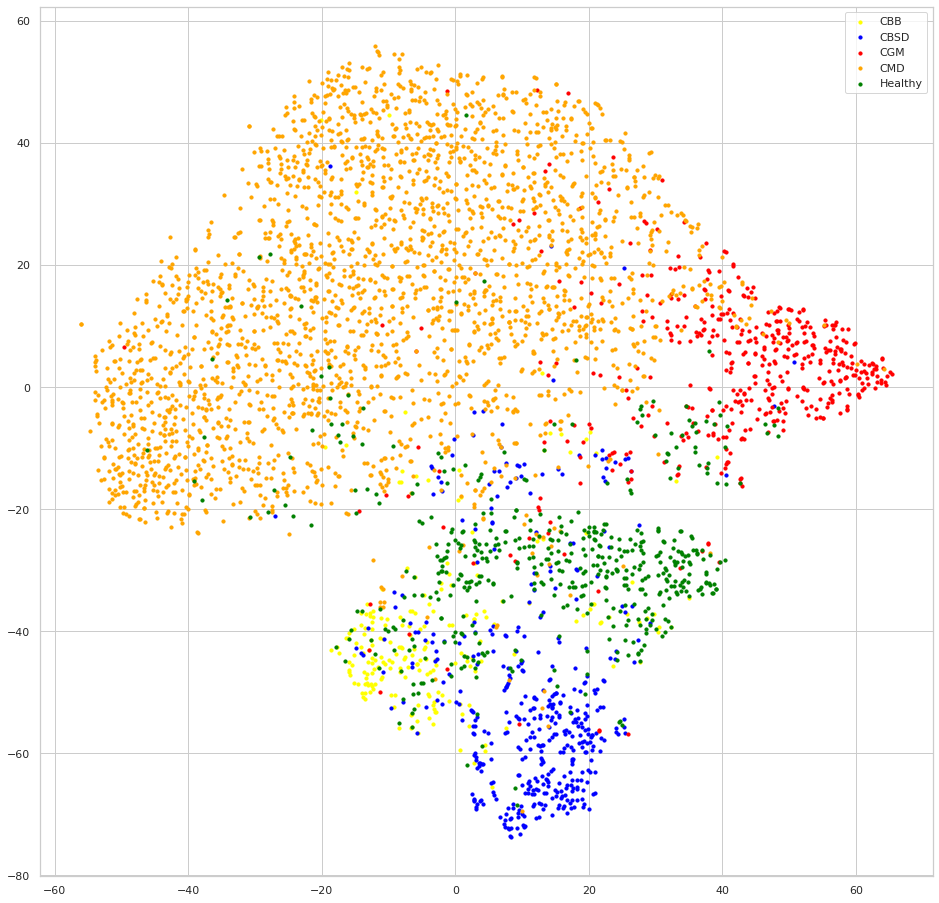

In [17]:
y_reg_true = np.concatenate(oof_reg_labels)
y_reg_pred = np.concatenate(oof_reg_pred)
embeddings_reg = np.concatenate(oof_reg_embed)

visualize_embeddings(embeddings_reg, y_reg_true)

## Supervised contrastive learning

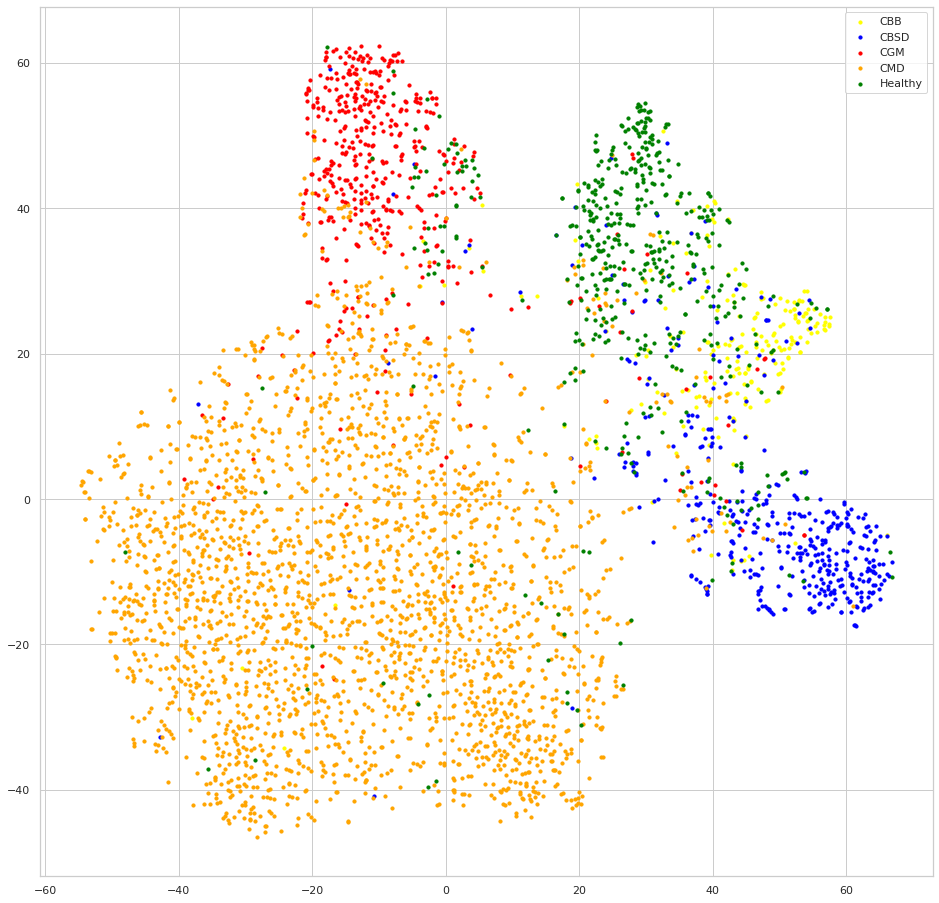

In [18]:
y_true = np.concatenate(oof_labels)
y_pred = np.concatenate(oof_pred)
embeddings_scl = np.concatenate(oof_embed)

visualize_embeddings(embeddings_scl, y_true)

# Model evaluation

Now we can evaluate the performance of the model, first, we can evaluate the usual metrics like, `accuracy`, `precision`, `recall`, and `f1-score`, `scikit-learn` provides the perfect function for this `classification_report`.

We are evaluating the model on the `OOF` predictions, it stands for `Out Of Fold`, since we are training using `K-Fold` our model will see all the data, and the correct way to evaluate each fold is by looking at the predictions that are not from that fold.

## OOF metrics (regular training)

In [19]:
print(classification_report(y_reg_true, y_reg_pred, target_names=CLASSES))

                              precision    recall  f1-score   support

    Cassava Bacterial Blight       0.55      0.70      0.61       217
Cassava Brown Streak Disease       0.82      0.81      0.81       437
        Cassava Green Mottle       0.79      0.83      0.81       478
      Cassava Mosaic Disease       0.97      0.95      0.96      2633
                     Healthy       0.71      0.68      0.70       514

                    accuracy                           0.87      4279
                   macro avg       0.77      0.79      0.78      4279
                weighted avg       0.88      0.87      0.88      4279



## OOF metrics (supervised contrastive learning)

In [20]:
print(classification_report(y_true, y_pred, target_names=CLASSES))

                              precision    recall  f1-score   support

    Cassava Bacterial Blight       0.60      0.68      0.63       217
Cassava Brown Streak Disease       0.80      0.81      0.80       437
        Cassava Green Mottle       0.77      0.84      0.80       478
      Cassava Mosaic Disease       0.96      0.95      0.96      2633
                     Healthy       0.73      0.68      0.70       514

                    accuracy                           0.88      4279
                   macro avg       0.77      0.79      0.78      4279
                weighted avg       0.88      0.88      0.88      4279



# Confusion matrix  (regular training)

Let's also take a look at the confusion matrix, this will give us an idea about what classes the model is mixing or having a hard time.

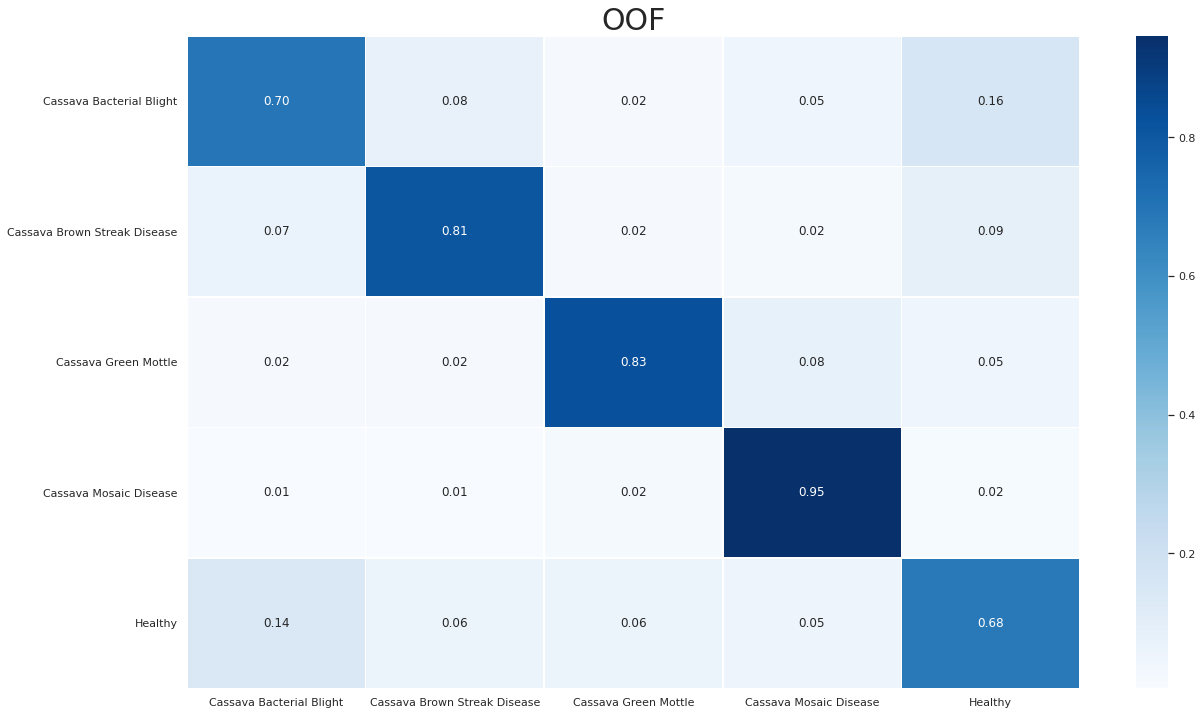

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
cfn_matrix = confusion_matrix(y_reg_true, y_reg_pred, labels=range(len(CLASSES)))
cfn_matrix = (cfn_matrix.T / cfn_matrix.sum(axis=1)).T
df_cm = pd.DataFrame(cfn_matrix, index=CLASSES, columns=CLASSES)
ax = sns.heatmap(df_cm, cmap='Blues', annot=True, fmt='.2f', linewidths=.5).set_title('OOF', fontsize=30)
plt.show()

# Confusion matrix (supervised contrastive learning)

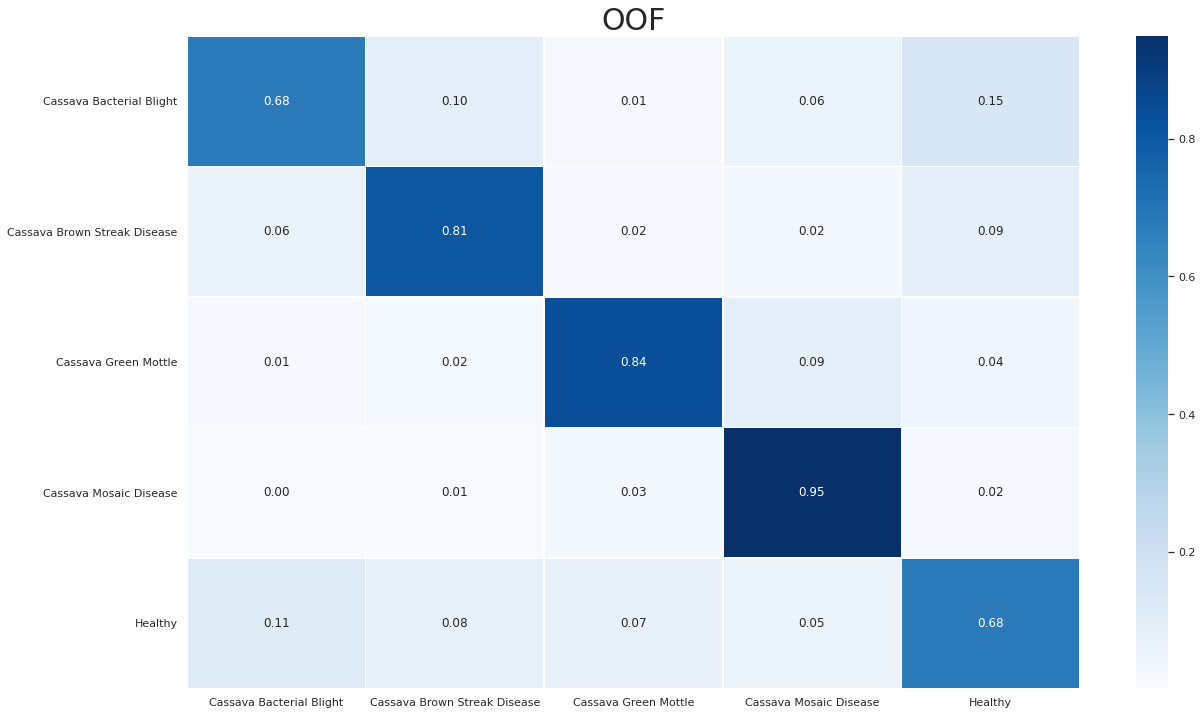

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
cfn_matrix = confusion_matrix(y_true, y_pred, labels=range(len(CLASSES)))
cfn_matrix = (cfn_matrix.T / cfn_matrix.sum(axis=1)).T
df_cm = pd.DataFrame(cfn_matrix, index=CLASSES, columns=CLASSES)
ax = sns.heatmap(df_cm, cmap='Blues', annot=True, fmt='.2f', linewidths=.5).set_title('OOF', fontsize=30)
plt.show()

# Visualize predictions

Finally, it is a good practice to always inspect some of the model's prediction by looking at the data, this can give an idea if the model is getting some predictions wrong because the data is really hard, or if it is because the model is actually bad.


### Class map
```
0: Cassava Bacterial Blight (CBB)
1: Cassava Brown Streak Disease (CBSD)
2: Cassava Green Mottle (CGM)
3: Cassava Mosaic Disease (CMD)
4: Healthy
```

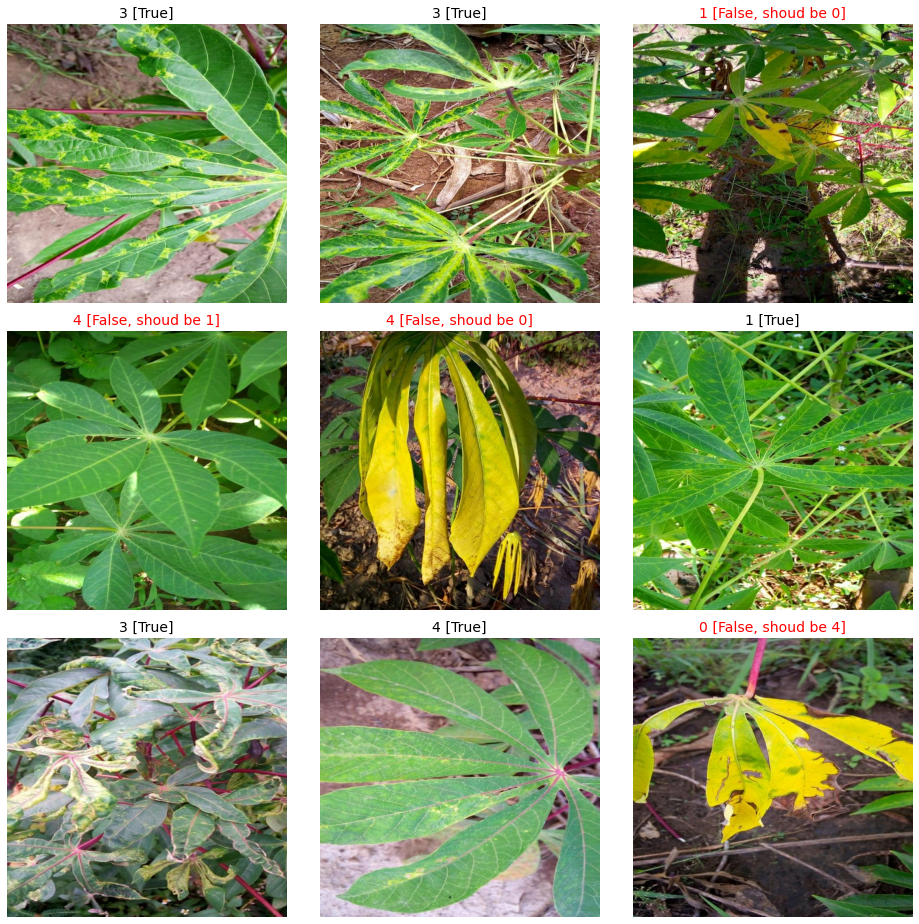

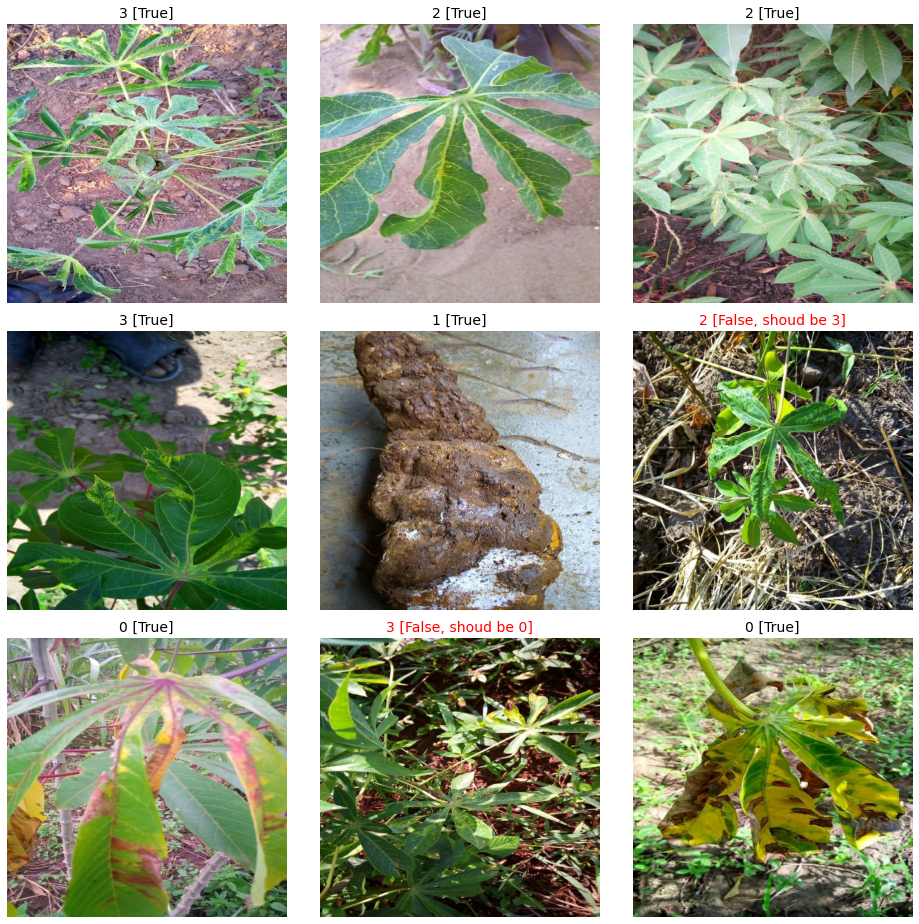

In [23]:
train_dataset = get_dataset(TRAINING_FILENAMES, ordered=True)
x_samp, y_samp = dataset_to_numpy_util(train_dataset, 18)

x_samp_1, y_samp_1 = x_samp[:9,:,:,:], y_samp[:9]
samp_preds_1 = model.predict(x_samp_1, batch_size=9)
display_9_images_with_predictions(x_samp_1, samp_preds_1, y_samp_1)

x_samp_2, y_samp_2 = x_samp[9:,:,:,:], y_samp[9:]
samp_preds_2 = model.predict(x_samp_2, batch_size=9)
display_9_images_with_predictions(x_samp_2, samp_preds_2, y_samp_2)